In [103]:
%%writefile car.cpp

#include <stdlib.h>
#include <iostream>
#include <fstream>
#include <string>
#include <cstring>
#include <omp.h>
#include <cstdio>
#include <math.h>
using namespace std;


// include omp header file here

#define RGB_COMPONENT_COLOR 255

struct PPMPixel {
    int red;
    int green;
    int blue;
};

typedef struct{
    int x, y, all;
    PPMPixel * data;
} PPMImage;

void readPPM(const char *filename, PPMImage& img){
    std::ifstream file (filename);
    if (file){
        std::string s;
        int rgb_comp_color;
        file >> s;
        if (s!="P3") {std::cout<< "error in format"<<std::endl; exit(9);}
        file >> img.x >>img.y;
        file >>rgb_comp_color;
        img.all = img.x*img.y;
        //std::cout << s << std::endl;
        //std::cout << "x=" << img.x << " y=" << img.y << " all=" <<img.all << std::endl;
        img.data = new PPMPixel[img.all];
        for (int i=0; i<img.all; i++){
            file >> img.data[i].red >>img.data[i].green >> img.data[i].blue;
        }

    }else{
        std::cout << "the file:" << filename << "was not found" << std::endl;
    }
    file.close();
}

void writePPM(char *filename, PPMImage & img){
    std::ofstream file (filename, std::ofstream::out);
    file << "P3"<<std::endl;
    file << img.x << " " << img.y << " "<< std::endl;
    file << RGB_COMPONENT_COLOR << std::endl;

    for(int i=0; i<img.all; i++){
        file << img.data[i].red << " " << img.data[i].green << " " << img.data[i].blue << (((i+1)%img.x ==0)? "\n" : " ");
    }
    file.close();
}

//
//write the function for shifting
//


void shiftPPM (PPMImage & image) {


    // initialization of three 1D arrays - RGB

    int* red = new int[image.all];
    
    for(int i = 0; i < image.all; ++i)
        red[i] = image.data[i].red;
    
    int* green = new int[image.all];
    
    for(int i = 0; i < image.all; ++i)
        green[i] = image.data[i].green;
          
    int* blue = new int[image.all];
    
    for(int i = 0; i < image.all; ++i)
        blue[i] = image.data[i].blue;
      
    
    // initialization of 3D array
    
    int*** image_array = new int**[image.x];
    
    for(int i = 0; i < image.x; ++i) {
        image_array[i] = new int*[image.y];
        for (int j = 0; j < image.y; j++) {
            image_array[i][j] = new int[3];       
        }
    }
    
    
    for(int i = 0; i < image.x; ++i) {
        for (int j = 0; j < image.y; j++) {
	    image_array[i][j][0] = red[i*image.y + j];
	    image_array[i][j][1] = green[i*image.y + j];  
	    image_array[i][j][2] = blue[i*image.y + j]; 
        }
    }
    

    // shift image
    
    for(int i = 0; i < image.x; ++i) {
        for (int j = 0; j < image.y; j++) {
            if (j == image.y - 1) {
            	image_array[i][j][0] = image_array[i][0][0];
            	image_array[i][j][1] = image_array[i][0][1];
            	image_array[i][j][2] = image_array[i][0][2];
            }
            else {
	        image_array[i][j][0] = image_array[i][j+1][0];  
	        image_array[i][j][1] = image_array[i][j+1][1];
	        image_array[i][j][2] = image_array[i][j+1][2];
	    } 
        }
    }
    
    // convert 2D to 1D array
    
    for (int i = 0; i < image.x; ++i) 
    {
        for (int j = 0; j < image.y; j++)
        {
            red[i*image.y + j] = image_array[i][j][0];
            green[i*image.y + j] = image_array[i][j][1];
            blue[i*image.y + j] = image_array[i][j][2];
        }
    }
    
    // convert 1D array to image PPM
    
    for (int i=0; i<image.all; i++){
            image.data[i].red = red[i];
            image.data[i].blue = blue[i];
            image.data[i].green = green[i];
    }


    // deallocate memory
    
    for (int i = 0; i < image.x; i++)
    {
        for (int j = 0; j < image.y; j++) {
            delete[] image_array[i][j];
        }
        delete[] image_array[i];
    }
    delete[] image_array;
    
    delete[] blue;
    delete[] green;
    delete[] red;
    
    //cout << "Shift is done." << endl;

}


int main(int argc, char *argv[]){
    PPMImage image;
    
    readPPM("car.ppm", image);
    
    for (int k = 1; k < 11;k++)
    {
        int shift_N = 10*k;
        double *time = new double[shift_N];
        double start, end;
        
        double start_final;
        double end_final;
        
        start_final = omp_get_wtime();
        for (int j = 0; j < shift_N; j++) {
        
            start = omp_get_wtime();		
            shiftPPM(image);
            end = omp_get_wtime();
            
            time[j] = end - start;
            
            string filename = "new_car_" + to_string(j) + ".ppm";
            char arr[filename.length() + 1]; 
    
            strcpy(arr, filename.c_str()); 
            //cout<<"String to char array conversion:\n";
          //  for (int i = 0; i < filename.length(); i++) 
          //cout << arr[i]; 
            
            writePPM(arr, image);
        }

            
        
        //cout << "------Time consumption------" << endl;
        
        //for (int i = 0; i < shift_N; i++) {
          // cout << time[i] << endl;
        //}
        
        end_final = omp_get_wtime();
        cout << end_final - start_final <<" " << shift_N << endl;
        
    }
    
    
    return 0;
}

Overwriting car.cpp


In [104]:
!g++ car.cpp -o car -fopenmp

In [105]:
!./car > result_car.txt

In [106]:
!cat result_car.txt

0.194897 10
0.34828 20
0.511273 30
0.700458 40
0.880313 50
1.06018 60
1.25367 70
1.40574 80
1.6235 90
1.71384 100


In [38]:
import cv2
for i in range(10):
  image = cv2.imread(f'new_car_{i}.ppm')
  cv2.imwrite(f'new_car_{i}.png',image)



import glob
from PIL import Image

# filepaths
fp_in = "new_car_*.png"
fp_out = "sequential_car.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=1000, loop=0)

In [114]:
%%writefile car_omp.cpp

#include <stdlib.h>
#include <iostream>
#include <fstream>
#include <string>
#include <cstring>
#include <omp.h>
using namespace std;


// include omp header file here

const int N_THREADS = omp_get_max_threads();

#define RGB_COMPONENT_COLOR 255

struct PPMPixel {
    int red;
    int green;
    int blue;
};

typedef struct{
    int x, y, all;
    PPMPixel * data;
} PPMImage;

void readPPM(const char *filename, PPMImage& img){
    std::ifstream file (filename);
    if (file){
        std::string s;
        int rgb_comp_color;
        file >> s;
        if (s!="P3") {std::cout<< "error in format"<<std::endl; exit(9);}
        file >> img.x >>img.y;
        file >>rgb_comp_color;
        img.all = img.x*img.y;
        //std::cout << s << std::endl;
        //std::cout << "x=" << img.x << " y=" << img.y << " all=" <<img.all << std::endl;
        img.data = new PPMPixel[img.all];
        for (int i=0; i<img.all; i++){
            file >> img.data[i].red >>img.data[i].green >> img.data[i].blue;
        }

    }else{
        std::cout << "the file:" << filename << "was not found" << std::endl;
    }
    file.close();
}

void writePPM(char *filename, PPMImage & img){
    std::ofstream file (filename, std::ofstream::out);
    file << "P3"<<std::endl;
    file << img.x << " " << img.y << " "<< std::endl;
    file << RGB_COMPONENT_COLOR << std::endl;

    for(int i=0; i<img.all; i++){
        file << img.data[i].red << " " << img.data[i].green << " " << img.data[i].blue << (((i+1)%img.x ==0)? "\n" : " ");
    }
    file.close();
}

//
//write the function for shifting
//


void shiftPPM (PPMImage & image) {

    int N_x = image.x;
    int N_y = image.y;
    
    
    // initialization of three 1D arrays - RGB
    int* red = new int[image.all];
    int* green = new int[image.all];
    int* blue = new int[image.all];
    
    // initialization of 3D array
    
    int*** image_array = new int**[N_x];
    
    for(int i = 0; i < N_x; ++i) {
        image_array[i] = new int*[N_y + 1];
        for (int j = 0; j < N_y + 1; j++) {
            image_array[i][j] = new int[3];       
        }
    }
        
    
    for(int i = 0; i < image.all; ++i)
        red[i] = image.data[i].red;
    

    for(int i = 0; i < image.all; ++i)
        green[i] = image.data[i].green;
         
 
    for(int i = 0; i < image.all; ++i)
        blue[i] = image.data[i].blue;
        
    int i,j;
      
#pragma omp parallel shared(red,green,blue, image_array,N_x,N_y) private(i,j) num_threads(N_THREADS)
{

    #pragma omp for collapse(2) 
    for (i = 0; i < N_x; ++i) {
        for (j = 0; j < N_y; j++) {
          image_array[i][j][0] = red[i*N_y + j];
          image_array[i][j][1] = green[i*N_y + j];  
          image_array[i][j][2] = blue[i*N_y + j]; 
        }
    }
    
    #pragma omp for
    for (i = 0; i < N_x; i++) {
        image_array[i][N_y][0] = red[i*N_y + 0];
        image_array[i][N_y][1] = green[i*N_y + 0];
        image_array[i][N_y][2] = blue[i*N_y + 0];
    }
    
    #pragma omp barrier

    // shift image
    
    //cout << "Array shift" << endl;
    
    #pragma omp for collapse(2)
    for(i = 0; i < N_x; ++i) {
        for (j = 0; j < N_y; j++) {
            image_array[i][j][0] = image_array[i][j+1][0];  
            image_array[i][j][1] = image_array[i][j+1][1];
            image_array[i][j][2] = image_array[i][j+1][2];
        }
    }
} // end parallel
    
    // convert 2D to 1D array
    #pragma omp parallel for collapse(2) 
    for (i = 0; i < N_x; ++i) 
    { 
        for (j = 0; j < N_y; j++)
        {
            red[i*N_y + j] = image_array[i][j][0];
            green[i*N_y + j] = image_array[i][j][1];
            blue[i*N_y + j] = image_array[i][j][2];
            
            //printf("tid = %d, red[%d] = %d\n", omp_get_thread_num(), i*N_y + j, red[i*N_y + j]);
        }
    }
    

    // convert 1D array to image PPM
    
    for (i=0; i<image.all; i++)
    {
            image.data[i].red = red[i];
            image.data[i].blue = blue[i];
            image.data[i].green = green[i];
    }


    // deallocate memory
    
    for (i = 0; i < N_x; i++)
    {
        for (j = 0; j < N_y; j++) {
            delete[] image_array[i][j];
        }
        delete[] image_array[i];
    }
    delete[] image_array;
    
    delete[] blue;
    delete[] green;
    delete[] red;
    
    //cout << "Shift is done." << endl;

}

int main(int argc, char *argv[]){
    PPMImage image;
    
    readPPM("car.ppm", image);
    
    for (int k = 1; k < 11;k++)
    {
        int shift_N = 10*k;
        double *time = new double[shift_N];
        double start, end;
        
        double start_final;
        double end_final;
        
        start_final = omp_get_wtime();
        for (int j = 0; j < shift_N; j++) {
        
            start = omp_get_wtime();		
            shiftPPM(image);
            end = omp_get_wtime();
            
            time[j] = end - start;
            
            string filename = "new_car_" + to_string(j) + ".ppm";
            char arr[filename.length() + 1]; 
    
            strcpy(arr, filename.c_str()); 
            //cout<<"String to char array conversion:\n";
          //  for (int i = 0; i < filename.length(); i++) 
          //cout << arr[i]; 
            
            writePPM(arr, image);
        }

            
        
        //cout << "------Time consumption------" << endl;
        
        //for (int i = 0; i < shift_N; i++) {
          // cout << time[i] << endl;
        //}
        
        end_final = omp_get_wtime();
        cout << end_final - start_final <<" " << shift_N << endl;
        
    }
    
    return 0;
}

Overwriting car_omp.cpp


In [115]:
!g++ car_omp.cpp -o caromp -fopenmp

In [116]:
!./caromp > result_car_omp.txt

In [117]:
!cat result_car_omp.txt

0.213679 10
0.435239 20
0.686328 30
0.927784 40
1.13607 50
1.43255 60
1.64851 70
1.90914 80
2.14855 90
2.42309 100


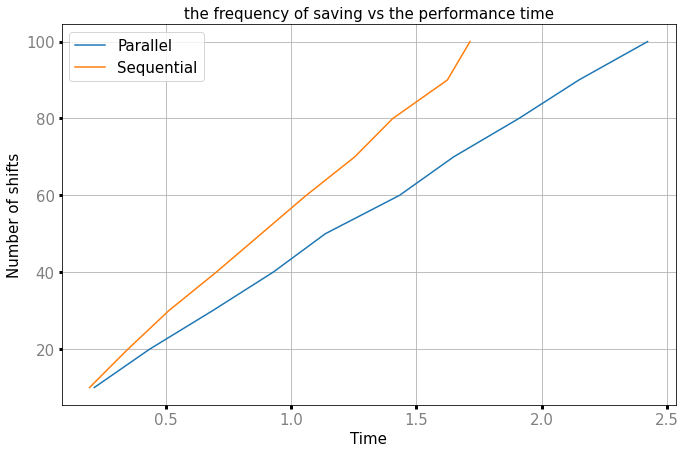

In [132]:
import matplotlib.pyplot as plt

X, Y = [], []
for line in open('result_car_omp.txt', 'r'):
  values = [float(s) for s in line.split()]
  X.append(values[0])
  Y.append(values[1])

X1, Y1 = [], []
for line in open('result_car.txt', 'r'):
  values = [float(s) for s in line.split()]
  X1.append(values[0])
  Y1.append(values[1])

plt.figure(figsize=(11,7))

plt.plot(X, Y, label = "Parallel")
plt.plot(X1, Y1, label = "Sequential")


plt.title('the frequency of saving vs the performance time',fontsize=15)
plt.xlabel('Time',fontsize=15)
plt.ylabel('Number of shifts',fontsize=15)
plt.tick_params(labelcolor='gray', labelsize=15, width=3)
plt.legend(fontsize=15)
plt.grid()
plt.show()


In [42]:
import cv2
for i in range(10):
  image = cv2.imread(f'new_car_{i}.ppm')
  cv2.imwrite(f'new_car_{i}.png',image)



In [43]:


import glob
from PIL import Image

# filepaths
fp_in = "new_car_*.png"
fp_out = "parallel_car.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=1000, loop=0)